In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# We need these two classes to set proper ticklabels for Cartopy maps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import pyproj
import verde as vd

In [2]:
# Fetch the GPS data from the U.S. West coast. 
data = vd.datasets.fetch_california_gps()
coordinates = (data.longitude.values, data.latitude.values)
region = vd.get_region(coordinates)
projection = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())

In [153]:
spacing = 20/60
chain = vd.Chain([
    ('trend', vd.VectorTrend(degree=1)),
    ('mean', vd.BlockMean(spacing*111e3, uncertainty=True)),
    ('spline', vd.Vector2D(poisson=0.5, spacing=spacing*3*111e3, damping=1e-4))])
chain.fit(projection(*coordinates), 
          (data.velocity_east, data.velocity_north),
          weights=(1/data.std_east**2, 1/data.std_north**2))
chain.named_steps['spline'].force_.size/2

88.0

In [154]:
grid = chain.grid(region, spacing=spacing, projection=projection,
                  dims=['latitude', 'longitude'])
mask = vd.distance_mask(np.meshgrid(grid.longitude, grid.latitude), (data.longitude, data.latitude), 
                       maxdist=0.5)
grid = grid.where(~mask)
grid.east_component.size

870

In [155]:
region

(235.69192473869998, 244.968197435, 32.2884540827, 41.9023257796)

In [156]:
def setup_map(ax, title):
    "Make a map of the given trend component on the given axes"
    ax.set_title(title)
    # Setup the map ticks
    ax.set_xticks(np.arange(-124, -115, 4), crs=crs)
    ax.set_yticks(np.arange(33, 42, 2), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.add_feature(cfeature.LAND, facecolor='#eeeeee')
    #ax.add_feature(cfeature.OCEAN)
    ax.set_extent((234, 246, 31, 43), crs=crs)

/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


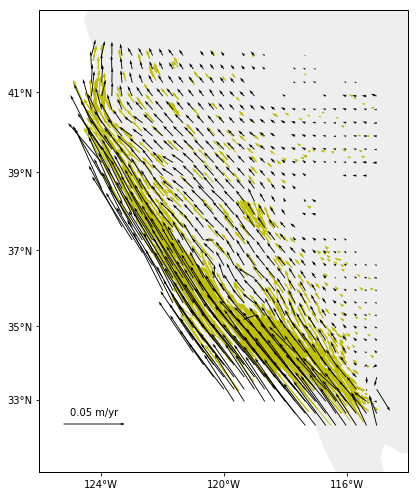

In [157]:
# Make a plot of the data using Cartopy to handle projections and coastlines
fig, axes = plt.subplots(1, 1, figsize=(9, 7),
                         subplot_kw=dict(projection=ccrs.Mercator()))
crs = ccrs.PlateCarree()
# Plot the two trend components
#ax = axes[0]
ax = axes
ax.quiver(data.longitude.values, data.latitude.values,
          data.velocity_east.values, data.velocity_north.values,
          scale=0.3, transform=crs, color='y')
#ax = axes[0]
#setup_map(ax, '')

tmp = ax.quiver(grid.longitude.values, grid.latitude.values,
          grid.east_component.values, grid.north_component.values,
          scale=0.3, transform=crs)


ax.quiverkey(tmp, 0.3, 0.15, 0.05, label='0.05 m/yr', coordinates='figure')

setup_map(ax, '')

plt.tight_layout()
plt.show()


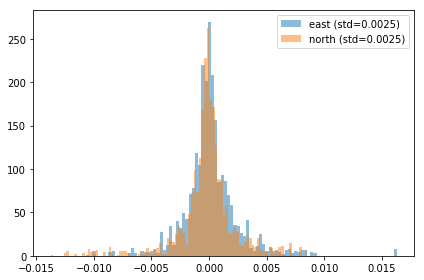

In [158]:
predicted = chain.predict(projection(*coordinates))
residuals = (data.velocity_east - predicted[0], data.velocity_north - predicted[1])
fig = plt.figure()
ax = plt.axes()
ax.hist(residuals[0], alpha=0.5, bins='auto', label='east (std={:.4f})'.format(residuals[0].std()))
ax.hist(residuals[1], alpha=0.5, bins='auto', label='north (std={:.4f})'.format(residuals[1].std()))
ax.legend()
plt.tight_layout()